# Прогноз продаж компьютерных игр

Наш проект посвящен прогнозированию продаж игр в интернет-магазине «Стримчик», который продаёт компьютерные игры по всему миру. Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт. Прогноз необходимо составить на 2017 год.

У нас есть две таблицы с необходимыми данными.

Таблица games.csv содержит следующие столбцы:
Name — название игры
Platform — платформа
Year_of_Release — год выпуска
Genre — жанр игры
NA_sales — продажи в Северной Америке (миллионы долларов)
EU_sales — продажи в Европе (миллионы долларов)
JP_sales — продажи в Японии (миллионы долларов)
Other_sales — продажи в других странах (миллионы долларов)
Critic_Score — оценка критиков (от 0 до 100)
User_Score — оценка пользователей (от 0 до 10)
Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Таблица rating.csv:
rating_type — рейтинг от организации ESRB (англ. Entertainment Software Rating Board)
decryption - возрастаная категория пользователей

* [Знакомство с данными](#Знакомство_с_данными)
* [Предобработка данных](#Предобработка_данных)
* [Анализ данных](#Анализ_данных)
* [Портрет пользователя каждого региона](#Портрет_пользователя_каждого_региона)
* [Исследование статистических показателей](#Исследование_статистических_показателей)
* [Проверим гипотезы](#Проверим_гипотезы)
* [Общие выводы](#Общие_выводы)

## Знакомство с данными <a id='Знакомство_с_данными'></a>

Импортируем необходимые библиотеки.

In [358]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from scipy import stats as st

Откроем файлы и изучим информацию.

In [359]:
games = pd.read_csv('/datasets/games.csv')
rating = pd.read_csv('/datasets/rating.csv')

In [360]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [361]:
rating

,rating_type,decryption
0,E,Для всех
1,M,От 17 лет
2,T,Подросткам 13—19 лет
3,E10+,Для всех старше 10 лет
4,K-A,Для всех(до 1998 года)
5,AO,Только для взрослых
6,EC,Для детей младшего возраста
7,RP,Рейтинг ожидается


## Предобработка данных <a id='Предобработка_данных'></a>

Наименования столбцов необходимо привести к нижнему регистру.

In [362]:
games.rename(columns={'Name': 'name', 'Platform': 'platform', 'Year_of_Release': 'year_of_release', 'Genre': 'genre', 'NA_sales': 'na_sales', 'EU_sales': 'eu_sales', 'JP_sales': 'jp_sales', 'Other_sales': 'other_sales', 'Critic_Score': 'critic_score', 'User_Score': 'user_score', 'Rating': 'rating'}, inplace=True)

Проверим, поменялись ли наименования столбцов.

In [363]:
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Проверим, какие типы данных содержат столбцы наших таблиц.

In [364]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [365]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
rating_type    8 non-null object
decryption     8 non-null object
dtypes: object(2)
memory usage: 256.0+ bytes


В data_rating нет проблем с пропусками, но с data_games придется поработать.

Чтобы не возникло проблем при расчете значений пользовательского рейтинга, приведем его тип к float64. 

In [366]:
games['user_score'] = pd.to_numeric(games['user_score'], errors='ignore')

Начнем работу с пропусками. Для начала посмотрим, сколько пропусков скрывается в нашей таблице.

In [367]:
games.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

В значениях пользовательского рейтинга есть достаточно много какого-то tbd. tbd с англиского 'Подлежит определению'. Скорее всего, это строки с рейтингом, который пользователи еще не проставили. Проверим нашу теорию.

In [368]:
games['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.5       2
0.2       2
1.1       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

In [369]:
games.columns = games.columns.str.lower()

def fill_na(df, col, val, tp=None, tbd=None):
    
    if tbd:
        df.loc[df[col] == 'tbd', col] = np.nan
        
        
    df[col] = df[col].fillna(val)
    
    if tp:
        df[col] = df[col].astype(tp)

#fill_na(games, 'year_of_release', 3000, int)
#fill_na(games, 'critic_score', -1, float)
#fill_na(games, 'user_score', -1, float, 1)
#fill_na(games, 'rating', 'unknown')


games['user_score'] = games['user_score'].apply(lambda x: np.nan if x == 'tbd' else x)
games.user_score = games.user_score.astype(float)

games = games[games['name'].notna()]

games.rename(columns={'year_of_release': 'year'}, inplace=True)

tbd по сути своей является NaN. Оценка пользователей на данный момент неизвестна, заменяем эти значения на -1. На 0 заменить мы эти значения не можем, ведь такое значение рейтинга уже может быть в данных.

Пропуски в оценках критиков так же меняем на -1.

Неизвестные даты релизов можно заменить неким большим числом, например 3000.

Посмотрим, какие значения содержит столбец rating.

In [370]:
games['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

rating - переменная количественная. В данном случае мы можем только заменить пропуски на "неизвестно" - "unknown". 

In [371]:
games['rating'] = games['rating'].fillna(value='unknown') 

Проверим, остались ли в нашей таблице пропуски.

In [372]:
games.isnull().sum()

name               0
platform           0
year             269
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score    8576
user_score      9123
rating             0
dtype: int64

Мешающих расчетам пропусков не осталось. Данные подготовлены к дальнейшему анализу.

## Анализ данных <a id='Анализ_данных'></a>

Добавим отдельный столбец с общими продажами игр и соединим таблицы games и rating.

In [373]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

In [374]:
games = games.merge(rating, left_on='rating', right_on='rating_type', how='left')

Рассмотрим периоды выхода игр. Построим boxplot и рассмотрим основную часть, показывающая квартили и доверительные интервалы медианы. Также взглянем  на гистограмму.

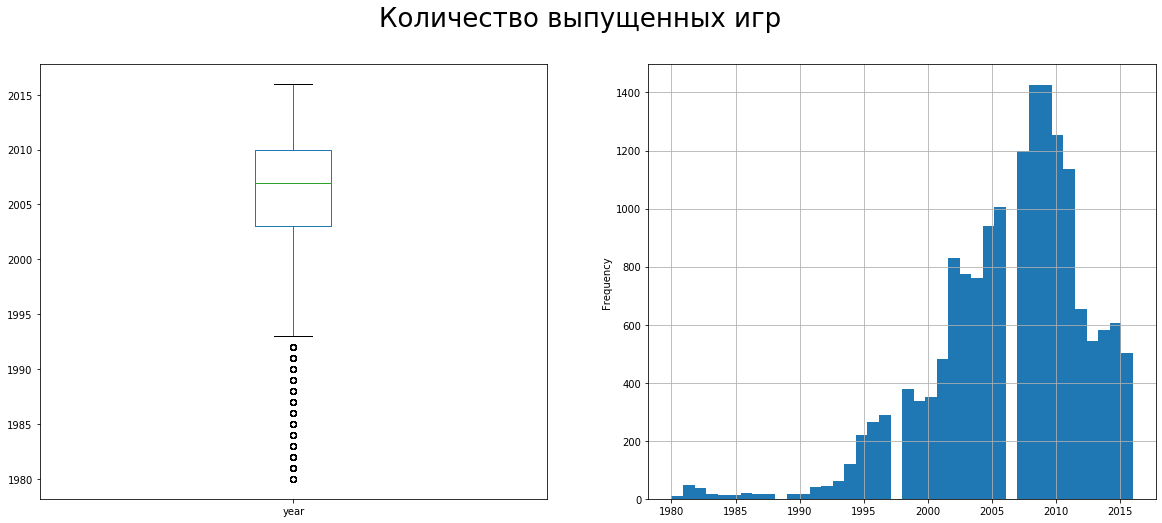

In [375]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8)) 


bxplt0_0 = games['year'].plot(kind='box', ax=axes[0])
bxplt0_0.set(xlabel='')


bxplt0_1 = games['year'].plot(kind='hist', bins=40, grid=True, ax=axes[1])
bxplt0_1.set(xlabel='')


fig.suptitle('Количество выпущенных игр', fontsize=26)
plt.show()

За актуальный период возьмём данные с 2012 года. В 2008-2011 гг., количество игр уменьшилось почти в 2 раза, данные распределены неравномерно. Может быть несколько факторов такого спада. Скорее всего, основная причина - массовый выход смартфонов на рынок и замена компьютерных игр на телефонные приложения.

In [376]:
actual_games = games.query('year >= 2012')

Наглядно предоставим распределение платформ по годам выпуска игр с помощью точечной гистограммы.

Text(-4.450000000000003, 0.5, 'Платформа')

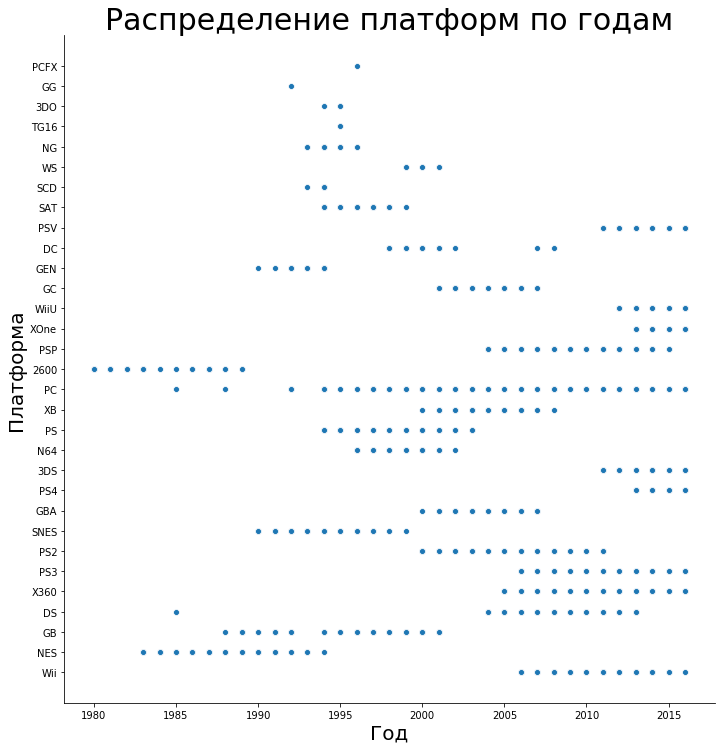

In [377]:
sns.relplot(data = games
            ,y = 'platform'
            ,x = 'year'
        
            ,height=10
            )

plt.title('Распределение платформ по годам', fontsize=30)
plt.xlabel('Год', fontsize=20)
plt.ylabel('Платформа', fontsize=20)

Какие-то платформы "канули в небытие" еще до 2000 г. Основная часть платформ вступают в игру с 2005 года.

Расчитаем среднее время жизни игровой платформы на примере трех известных платформ.

In [378]:
actual_platforms = ['3DS', 'XOne', 'PS4']

In [379]:
platform_lifetime = games[~games['platform'].isin(actual_platforms)].groupby('platform').agg({'year':['min', 'max']}).reset_index()
platform_lifetime['lifetime'] = platform_lifetime['year']['max'] - platform_lifetime['year']['min']
platform_lifetime.sort_values(by='lifetime', ascending=False).reset_index(drop=True)

platform    year         lifetime
                min     max         
0        PC  1985.0  2016.0     31.0
1        DS  1985.0  2013.0     28.0
2        GB  1988.0  2001.0     13.0
3      X360  2005.0  2016.0     11.0
4       PSP  2004.0  2015.0     11.0
5       NES  1983.0  1994.0     11.0
6       PS2  2000.0  2011.0     11.0
7        DC  1998.0  2008.0     10.0
8       Wii  2006.0  2016.0     10.0
9       PS3  2006.0  2016.0     10.0
10     2600  1980.0  1989.0      9.0
11     SNES  1990.0  1999.0      9.0
12       PS  1994.0  2003.0      9.0
13       XB  2000.0  2008.0      8.0
14      GBA  2000.0  2007.0      7.0
15      N64  1996.0  2002.0      6.0
16       GC  2001.0  2007.0      6.0
17      PSV  2011.0  2016.0      5.0
18      SAT  1994.0  1999.0      5.0
19      GEN  1990.0  1994.0      4.0
20     WiiU  2012.0  2016.0      4.0
21       NG  1993.0  1996.0      3.0
22       WS  1999.0  2001.0      2.0
23      3DO  1994.0  1995.0      1.0
24      SCD  1993.0  1994.0      1.0
25     PCFX  1996.0  1996.0      0.0
26       GG  1992.0  1992.0      0.0
27     TG16  1995.0  1995.0      0.0

In [380]:
platform_lifetime['lifetime'].mean()
platform_lifetime['lifetime'].median()

7.5

In [381]:
def drop_anomalies(df, col):
    q1 = df[col].quantile(0.25)                 
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    iqr_test = (df[col] >= (q1 - 1.5 * iqr)) & (df[col] <= (q3 + 1.5 * iqr))

    return df.loc[iqr_test]

In [382]:
drop_anomalies(platform_lifetime, 'lifetime')['lifetime'].median()
drop_anomalies(platform_lifetime, 'lifetime')['lifetime'].mean()

6.384615384615385

In [383]:
platform_lifetime[['lifetime']].describe().loc[['mean', 'std', 'min', 'max']]

,lifetime
,
mean,8.035714
std,7.239205
min,0.000000
max,31.000000


In [384]:
(drop_anomalies(platform_lifetime, 'lifetime'))[['lifetime']].describe().loc[['mean', 'std', 'min', 'max']]

,lifetime
,
mean,6.384615
std,4.089762
min,0.000000
max,13.000000


Среднее время жизни игровой платформы - 8 лет (медианное значаение не меняется при наличии выбросов и их отсутствии, без аномалий - 6 лет +- 4 года).

Из графика видно что:

больше всего продаж у платформ X360, XOne, PS4, Wii, PS3, WiiU, 3DS
Из вышеперечисленных платформ по сводной таблице делаем вывод:

X360 устарела, в 2016 году продажи упали почти что в 0
тоже самое можно сказать о Wii и WiiU
PS3 тоже выбывает из дальнейших соревнований - у неё дела ненамного лучше
PS4, 3DS и XOne чувствуют себя лучше всех в 2016 году
Так же стоит отметить что продажи на всех платформах очень сильно упали за последние 2-3 года (единственное исключение - относительно свежий XOne и PS4).

Сравним продажи игр на разных платформах.

Рассмотрим таблицу с продажами игр по годам.

In [385]:
sales = actual_games.pivot_table(index=['platform', 'year'], values='total_sales', aggfunc='sum')

In [386]:
sales

total_sales
platform year               
3DS      2012.0        51.36
         2013.0        56.57
         2014.0        43.76
         2015.0        27.78
         2016.0        15.14
DS       2012.0        11.01
         2013.0         1.54
PC       2012.0        23.22
         2013.0        12.38
         2014.0        13.28
         2015.0         8.52
         2016.0         5.25
PS3      2012.0       107.36
         2013.0       113.25
         2014.0        47.76
         2015.0        16.82
         2016.0         3.60
PS4      2013.0        25.99
         2014.0       100.00
         2015.0       118.90
         2016.0        69.25
PSP      2012.0         7.69
         2013.0         3.14
         2014.0         0.24
         2015.0         0.12
PSV      2012.0        16.19
         2013.0        10.59
         2014.0        11.90
         2015.0         6.25
         2016.0         4.25
Wii      2012.0        21.71
         2013.0         8.59
         2014.0         3.75
         2015.0         1.14
         2016.0         0.18
WiiU     2012.0        17.56
         2013.0        21.65
         2014.0        22.03
         2015.0        16.35
         2016.0         4.60
X360     2012.0        99.74
         2013.0        88.58
         2014.0        34.74
         2015.0        11.96
         2016.0         1.52
XOne     2013.0        18.96
         2014.0        54.07
         2015.0        60.14
         2016.0        26.15

Построим гистограмму boxplot по глобальным продажам с разбивкой по платформам.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(0, 2)

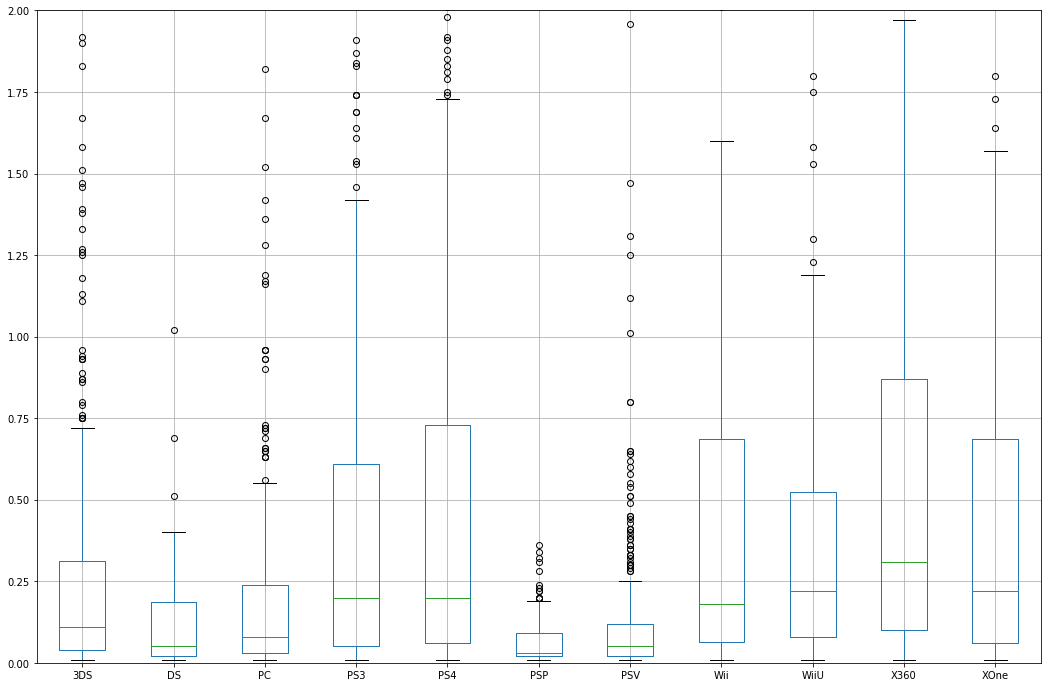

In [387]:
fig,ax = plt.subplots(figsize=(18,12))

actual_games.pivot_table(values='total_sales', index=['name'],
                                                 columns='platform').boxplot(
                                                ax=ax, grid=True)

ax.set_ylim(0,2)

Из графика видно, что больше всего продаж у платформ X360, XOne, PS4, Wii, PS3, WiiU, 3DS.
Из вышеперечисленных платформ по сводной таблице делаем вывод, что продажи за интересующий нас период выше всего у PS4, 3DS и XOne.
Так же стоит отметить что продажи на всех платформах очень сильно упали за последние 2-3 года.

Сравним выбранные платформы по основным показателям.

In [388]:
actual_games[actual_games['platform'].isin(['PS4', '3DS', 'XOne'])].pivot_table(values='total_sales', 
                          index=['name'],columns='platform').describe()

platform,3DS,PS4,XOne
count,396.000000,392.000000,247.000000
mean,0.491439,0.801378,0.645020
std,1.387161,1.609456,1.036139
min,0.010000,0.010000,0.010000
25%,0.040000,0.060000,0.060000
50%,0.110000,0.200000,0.220000
75%,0.312500,0.730000,0.685000
max,14.600000,14.630000,7.390000


Больше всего продаж у платформы 3DS, однако у неё и самый низкий показатель средний цены продажи (скорее всего там много игр по низким ценам), в то время как у PS4 игр продано почти столько же, но средняя цена почти на 40% выше. 
PS4 можно назвать топ-платформой для продажи игр. 

Проверим, есть ли связь между продажами и оценкой игр. Для этого построим диаграммамы рассеивания и корреляции.

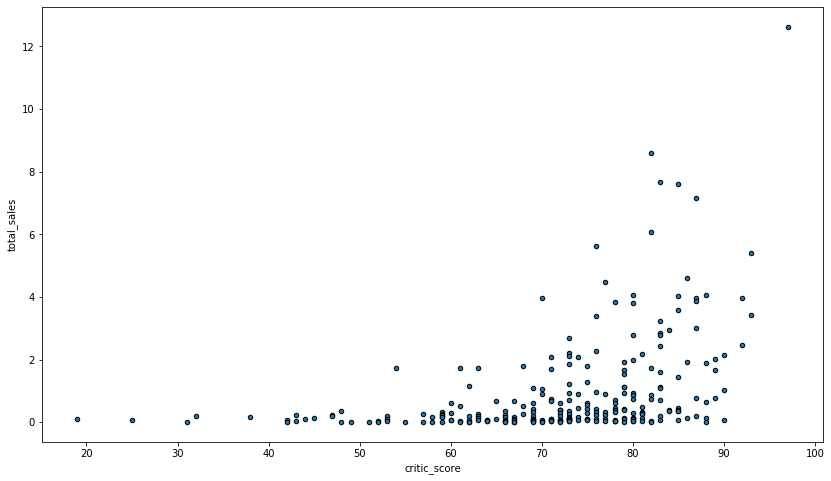

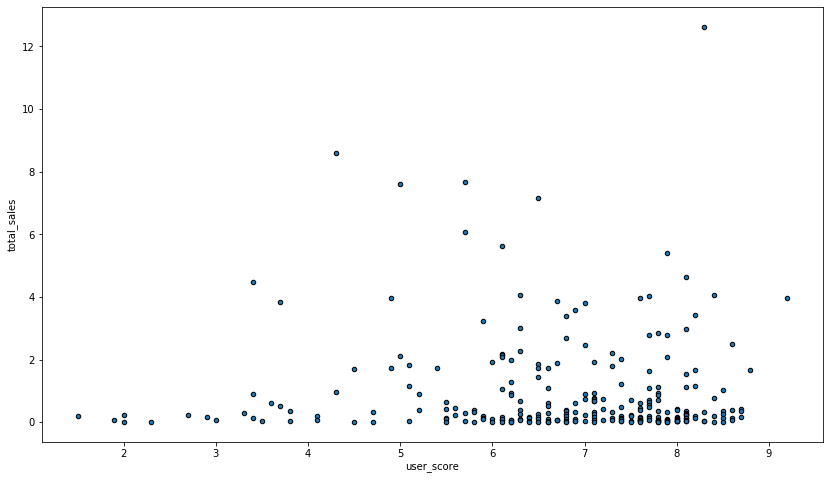

In [389]:
def plot_critics(df, platform, cols, sales):
    for col in cols:
        df_temp = df[(df['platform'] == platform) & (df[col] > 0)].copy()
        df_temp.plot(kind='scatter', x=col, y=sales, ec='black', figsize=(14,8))
        
        

plot_critics(games, 'PS4', ['critic_score', 'user_score'], 'total_sales')

In [390]:
games[games['platform'] == 'PS4'].corr()[['total_sales']].drop(['year',
                                                                'na_sales', 
                                                                'eu_sales',
                                                                'jp_sales', 
                                                                'other_sales',
                                                                'total_sales'])

,total_sales
critic_score,0.406568
user_score,-0.031957


Линейной зависимости между продажами и пользовательской оценкой игр нет. Коэффициэнт корреляции несущественный. 
Оценка критиков имеет больший вес. И в том, и в другом случае основные продажи все-таки приходятся на игры с более высоким рейтингом.

Рассмотрим зависимость продаж игр от оценок критиков и пользователей на разных платформах.

In [391]:
platforms = ['X360', 'XOne', 'PS4', 'Wii', 'PS3', 'WiiU', '3DS']
sales = 'total_sales'

In [392]:
def get_corr(df, cols, sales):
    df_final = pd.DataFrame()
    
    for col in cols:
        
        df_temp = df[df['platform'] == col][['total_sales', 'user_score', 'critic_score']].corr()[['total_sales']]
        
        df_temp.columns = [col]
        
        if df_final.shape[0] == 0:
            df_final = df_temp.copy()
        else:
            df_final = df_final.merge(df_temp, left_index=True, right_index=True)
        
        

    return df_final.drop('total_sales')

In [393]:
get_corr(games, platforms, sales)

,X360,XOne,PS4,Wii,PS3,WiiU,3DS
user_score,0.114459,-0.068925,-0.031957,0.112414,0.126691,0.400219,0.224808
critic_score,0.393736,0.416998,0.406568,0.177560,0.432432,0.348380,0.349401


In [394]:
get_corr(games, platforms, sales).describe().drop('count')

,X360,XOne,PS4,Wii,PS3,WiiU,3DS
mean,0.254097,0.174037,0.187305,0.144987,0.279561,0.374299,0.287104
std,0.197479,0.343600,0.310084,0.046065,0.216191,0.036656,0.088101
min,0.114459,-0.068925,-0.031957,0.112414,0.126691,0.348380,0.224808
25%,0.184278,0.052556,0.077674,0.128701,0.203126,0.361340,0.255956
50%,0.254097,0.174037,0.187305,0.144987,0.279561,0.374299,0.287104
75%,0.323917,0.295517,0.296937,0.161274,0.355997,0.387259,0.318253
max,0.393736,0.416998,0.406568,0.177560,0.432432,0.400219,0.349401


Оценки критиков оказывают больше влияние на продажи, чем оценки пользователей. На "новых" платформах (XOne и PS4) оценка игроков отрицательная (игроки ещё толком "не распробовали" платформу и нормальных отзывов очень мало (либо их вообще нет). В целом показатели по топ-платформе и по другим платформам идентичны и не оказывают существенного влияния на продажи.

Сравним предоставленные в таблице данные по сумме и количеству продаж.

Text(0, 0.5, 'Количество игр')

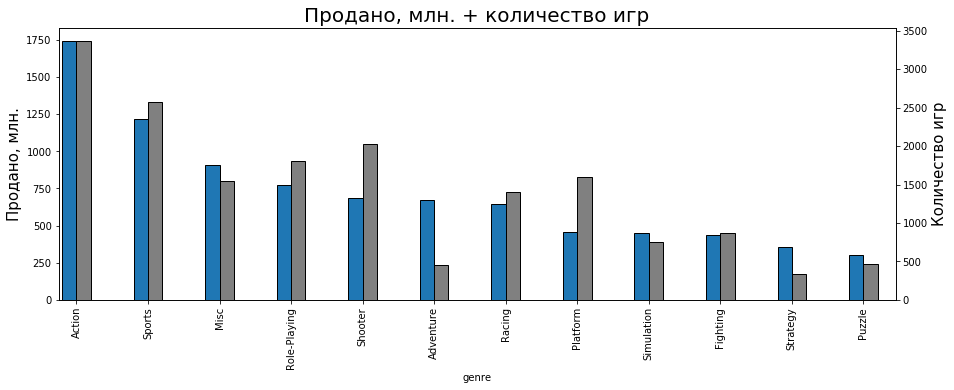

In [395]:
fig, ax_f = plt.subplots()
ax_c = ax_f.twinx()

pivot_table = games.groupby('genre').agg({'name': 'count', 
                                          'total_sales': 'sum'}).sort_values(by='name', ascending=False)

p1 = pivot_table['name']
p1.plot(kind='bar', figsize=(15,5), ec='black', ax=ax_c, width=0.2, position=1)

p2 = pivot_table['total_sales']
p2.plot(kind='bar', figsize=(15,5), ec='black', ax=ax_f, width=0.2, color='grey', position=0)

ax_f.set_title('Продано, млн. + количество игр', fontsize=20)
ax_f.set_ylabel('Продано, млн.', fontsize=15)
ax_c.set_ylabel('Количество игр', fontsize=15)

Больше всего продано игр жанра Action, второе-третье места занимают игры спортивного жанра и игры "смешанного" жанра - Miscellaneous. Хуже всего дела обстоят у стратегий и паззлов (головоломок)
По сумме продаж также лидируют игры жанра Action и спорт. На третьем месте по выручке шутеры. Меньше всего принесли продажи стратегий, пазлов и приключений.
Однако не стоит забывать, что производство игр в жанрах Action или Shooter обходится сильно дороже, чем производство Puzzle-игр.

## Портрет пользователя каждого региона <a id='Портрет_пользователя_каждого_региона'></a>

Составим "портрет" пользователей игрового пространства. Кто они? Сколько им лет? Где они живут? И сколько приносят денег компании? Для анализа возьмем данные начиная с 2012 года.

In [396]:
def region_analysis(df, cols, regions, kind='bar', rotate=70):
    dc = {'na_sales': None, 'eu_sales': 'darkred', 'jp_sales': 'darkgreen'}
    dt = {
            1:
                {
                    'na_sales': 'Продажи в Северной Америке', 
                    'eu_sales': 'Продажи в Европе', 
                    'jp_sales': 'Продажи в Японии'
                },
            2:
                {
                    'na_sales': 'Жанры в Северной Америке', 
                    'eu_sales': 'Жанры в Европе', 
                    'jp_sales': 'Жанры в Японии'
                },
            3:
                {
                    'na_sales': 'Рейтинг в Северной Америке', 
                    'eu_sales': 'Рейтинг в Европе', 
                    'jp_sales': 'Рейтинг в Японии'
                }
    }    
    
    i = 0
    for col in cols:
        j = 0
        for region in regions:
            df_temp = df.groupby(col).agg({region: 'sum'}).sort_values(by=region)
            df_temp = df_temp.tail()

            plot = df_temp.plot(kind=kind,
                                ax=axes[i, j], 
                                fontsize=18, 
                                rot=rotate,
                                color=dc[region],
                                title=dt[i+1][region]
                                )
            plot.legend([region], prop={'size': 20})
            plot.set_xlabel('')
            plot.title.set_size(25)

            j += 1
            
        i += 1


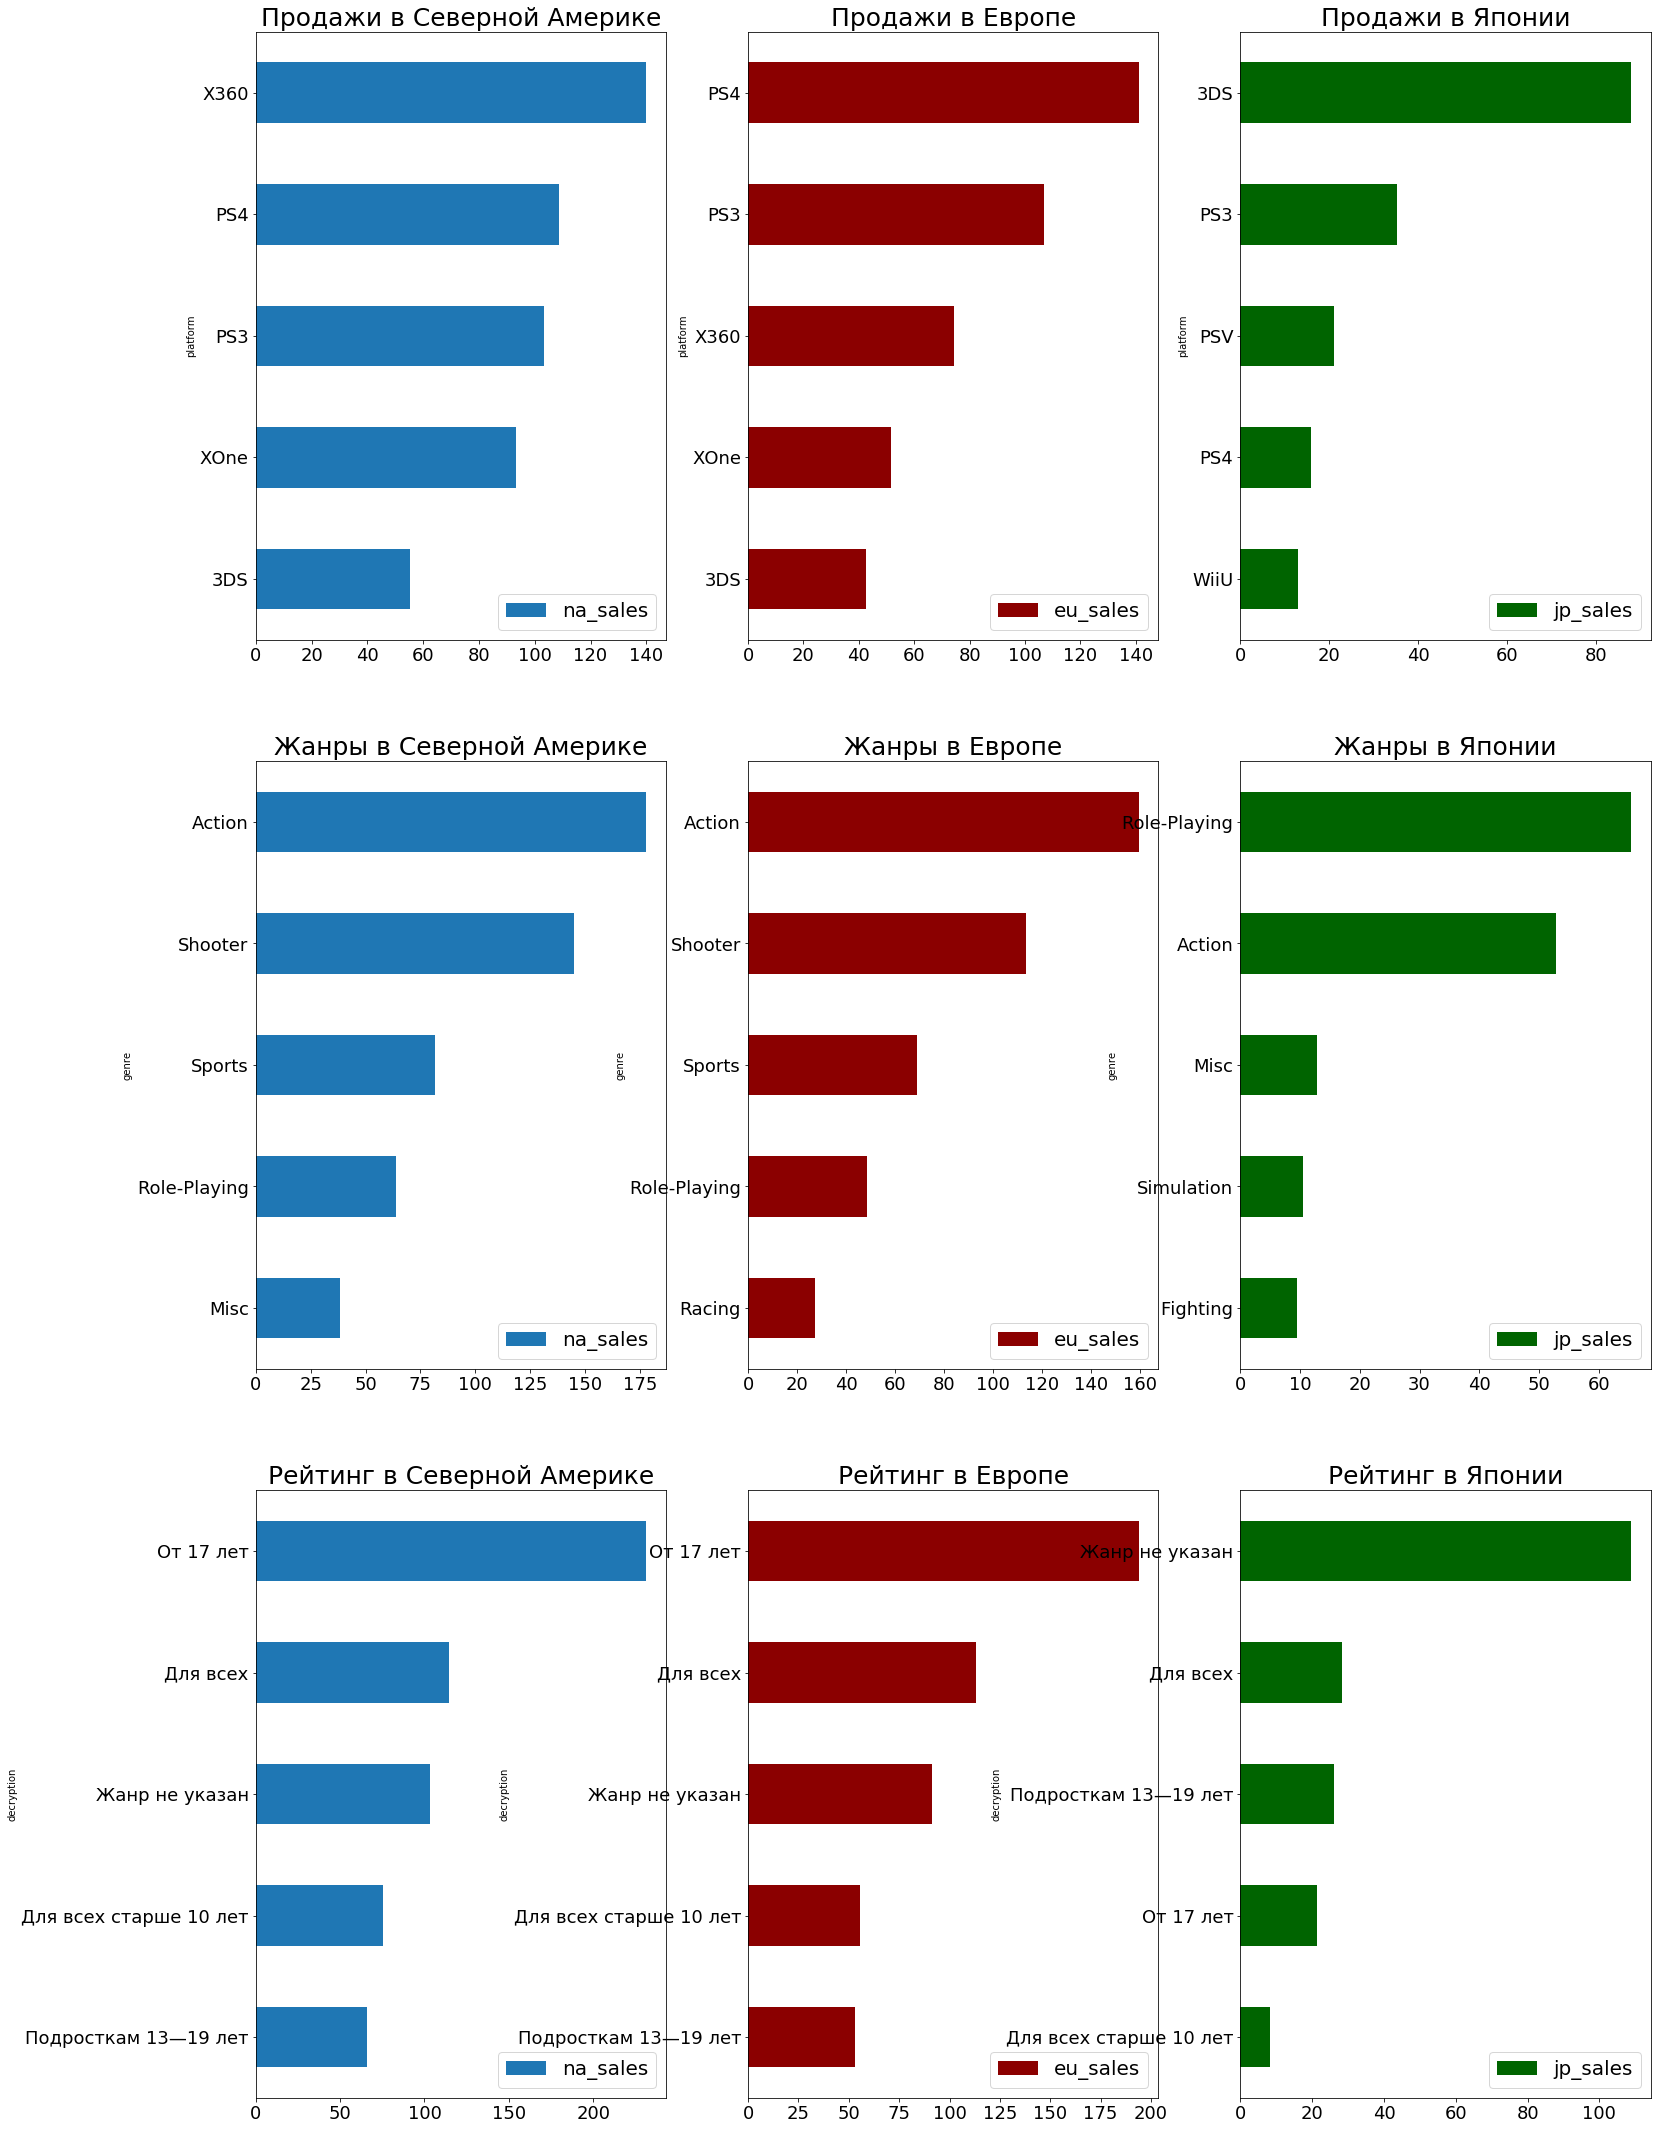

In [397]:
regions = ['na_sales', 'eu_sales', 'jp_sales']
cols = ['platform', 'genre', 'decryption']
fig, axes = plt.subplots(3, 3, figsize=(25,38))

region_analysis(actual_games.fillna({'decryption': 'Жанр не указан'}), cols, regions, 'barh', None)

Игроки из Северной Америки и Европы предпочитают одни и те же жанры игр, в то время как в Японии люди играют совсем в другие игры (скорее всего это связано с менталитетом).

В Северной Америке и Европе наиболее популярными игровыми платформами являются X360, PS3 и PS4. Самые популярные жанры - Action, Shooter и Sports. Возраст игроков от 17 лет, далее идёт рейтинг "Для всех" и "Старше 10 лет"

В Японии наиболее популярными платформами являются 3DS, PS3, PSV. Японцы предпочитают ролевые игры, Action, а так же смесь жанров (Mics). Возраст игроки предпочитают не указывать.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Портрет типичного пользователя каждого из регионов получен. Приведены все необходимые графики. Здорово, что отмечены индивидуальные особенности каждого региона. 

</div>

## Исследование статистических показателей <a id='Исследование_статистических_показателей'></a>

Посмотрим, как изменяется пользовательский рейтинг и рейтинг критиков в различных жанрах? Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы.

In [398]:
genre_score = games.groupby('genre').agg({'user_score': 'mean', 'critic_score': 'mean'})

In [399]:
genre_score

,user_score,critic_score
genre,,
Action,7.054044,66.629101
Adventure,7.133000,65.331269
Fighting,7.302506,69.217604
Misc,6.819362,66.619503
Platform,7.301402,68.058350
Puzzle,7.175000,67.424107
Racing,7.036193,67.963612
Role-Playing,7.619515,72.652646
Shooter,7.041883,70.181144


In [400]:
genre_score['user_score'].mean()

7.156156057348038

In [401]:
genre_score['user_score'].std()

0.20609248475408395

In [402]:
genre_score['user_score'].var()

0.04247411227211233

In [403]:
genre_score['critic_score'].mean()

68.89591006609142

In [404]:
genre_score['critic_score'].std()

2.3803162829873687

In [405]:
genre_score['critic_score'].var()

5.665905607054802

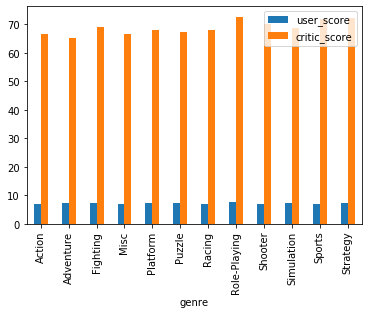

In [406]:
genre_score.plot(kind='bar')

Построим гистограмму, отображающую зависимость рейтинга пользователей от жанра игр.

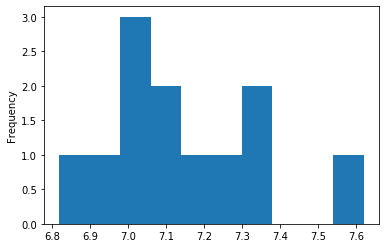

In [407]:
genre_score['user_score'].plot(kind='hist')

На мой взгляд более наглядно выглядит столбчатая гистограмма, повернутая по горизонтали. Тут мы сразу видим какие жанры больше нравятся пользователям. С небольшим отрывом побеждают ролевые игры.

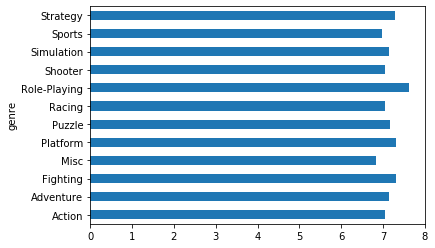

In [408]:
genre_score['user_score'].plot(kind='barh')

Гистограмма оценок жанров от критиков:

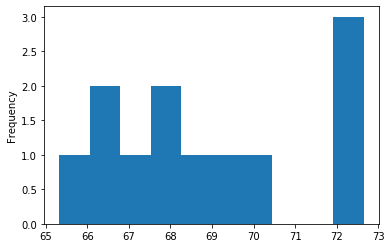

In [409]:
genre_score['critic_score'].plot(kind='hist')

И столбчатая гистограмма:

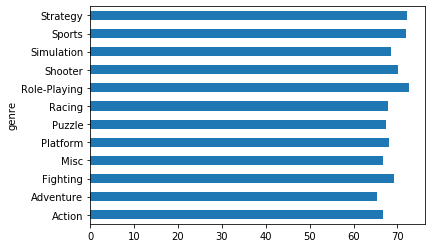

In [410]:
genre_score['critic_score'].plot(kind='barh')

И критикам больше нравятся ролевые игры. Но разрыв небольшой.

Построим гистограмму зависимостей рейтинга критиков и жанров.

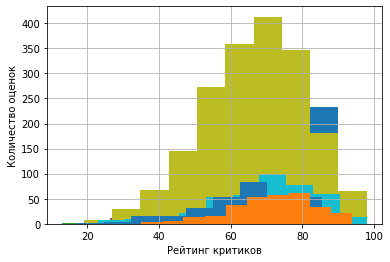

In [444]:
for x in games.genre.unique():
    games.query('genre == @x')['critic_score'].hist()
    plt.xlabel('Рейтинг критиков')
    plt.ylabel('Количество оценок')

In [ ]:
Построим гистограмму зависимостей рейтинга пользователей и жанров.

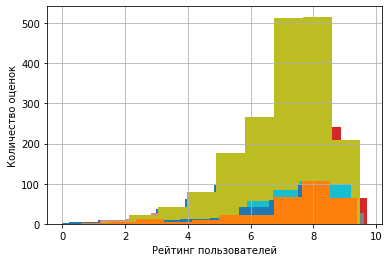

In [445]:
for x in games.genre.unique():
    games.query('genre == @x')['user_score'].hist()
    plt.xlabel('Рейтинг пользователей')
    plt.ylabel('Количество оценок')

Построим отдельно по каждому жанру гистограммы зависимостей рейтинга критиков и каждого из жанров.

Text(0, 0.5, 'Количество оценок')

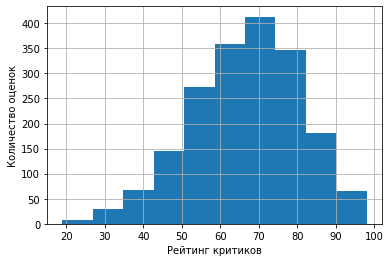

In [413]:
games.query('genre == "Action"')['critic_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Text(0, 0.5, 'Количество оценок')

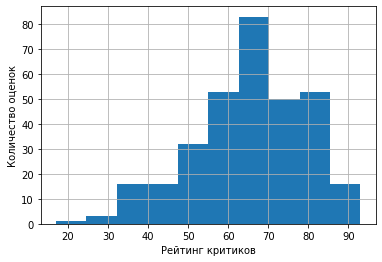

In [414]:
games.query('genre == "Adventure"')['critic_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Text(0, 0.5, 'Количество оценок')

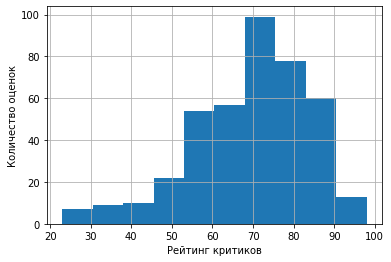

In [415]:
games.query('genre == "Fighting"')['critic_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Text(0, 0.5, 'Количество оценок')

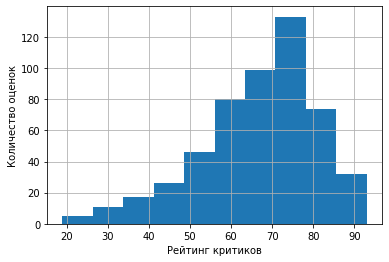

In [416]:
games.query('genre == "Misc"')['critic_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Text(0, 0.5, 'Количество оценок')

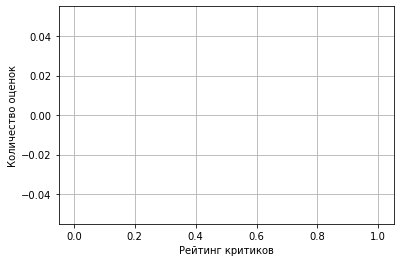

In [417]:
games.query('genre == "Platform	"')['critic_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Text(0, 0.5, 'Количество оценок')

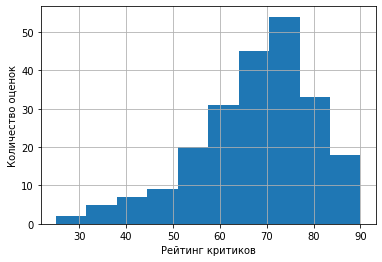

In [418]:
games.query('genre == "Puzzle"')['critic_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Text(0, 0.5, 'Количество оценок')

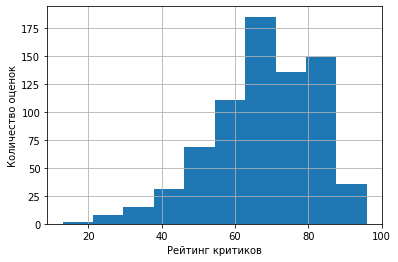

In [419]:
games.query('genre == "Racing"')['critic_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Text(0, 0.5, 'Количество оценок')

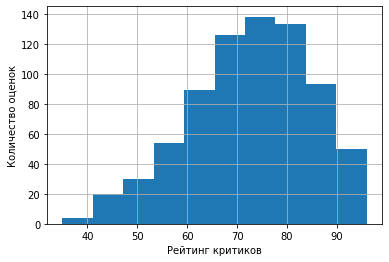

In [420]:
games.query('genre == "Role-Playing"')['critic_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Text(0, 0.5, 'Количество оценок')

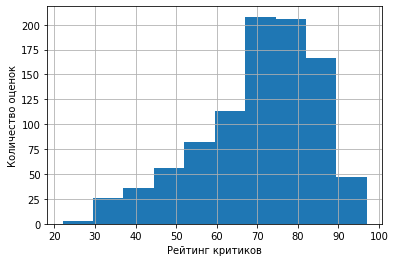

In [421]:
games.query('genre == "Shooter"')['critic_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Text(0, 0.5, 'Количество оценок')

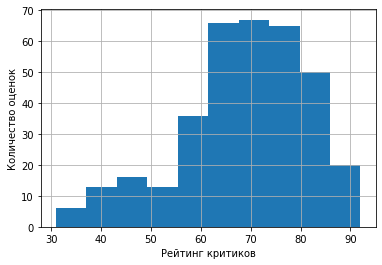

In [422]:
games.query('genre == "Simulation"')['critic_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Text(0, 0.5, 'Количество оценок')

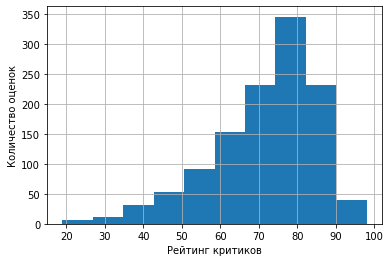

In [423]:
games.query('genre == "Sports"')['critic_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Text(0, 0.5, 'Количество оценок')

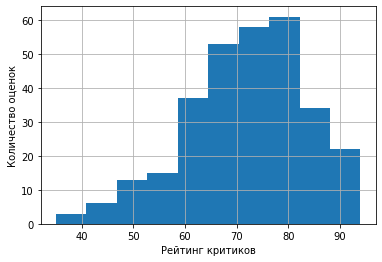

In [424]:
games.query('genre == "Strategy"')['critic_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Теперь построим отдельно по каждому жанру гистограммы зависимостей рейтинга по и каждого из жанров.

Text(0, 0.5, 'Количество оценок')

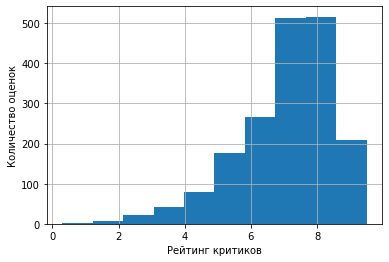

In [425]:
games.query('genre == "Action"')['user_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Text(0, 0.5, 'Количество оценок')

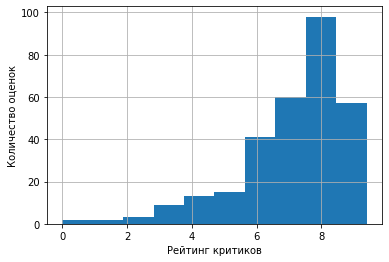

In [426]:
games.query('genre == "Adventure"')['user_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Text(0, 0.5, 'Количество оценок')

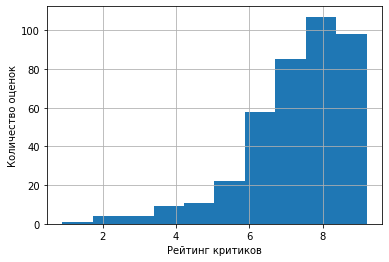

In [427]:
games.query('genre == "Fighting"')['user_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Text(0, 0.5, 'Количество оценок')

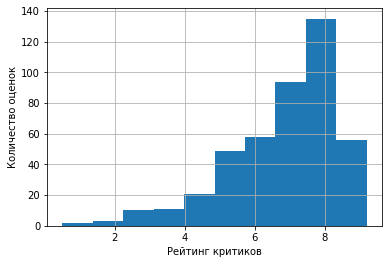

In [428]:
games.query('genre == "Misc"')['user_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Text(0, 0.5, 'Количество оценок')

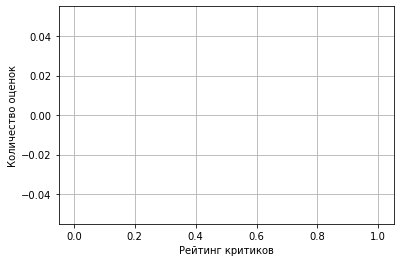

In [429]:
games.query('genre == "Platform	"')['user_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Text(0, 0.5, 'Количество оценок')

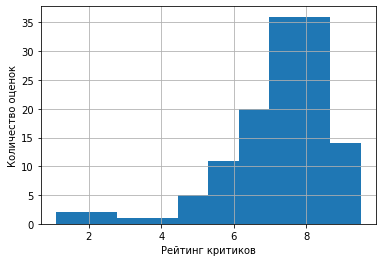

In [430]:
games.query('genre == "Puzzle"')['user_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Text(0, 0.5, 'Количество оценок')

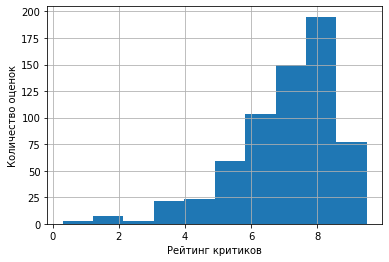

In [431]:
games.query('genre == "Racing"')['user_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Text(0, 0.5, 'Количество оценок')

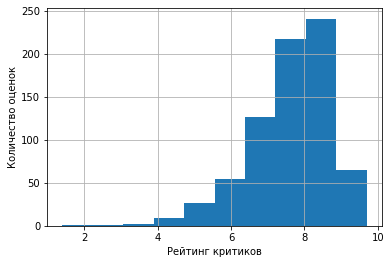

In [432]:
games.query('genre == "Role-Playing"')['user_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Text(0, 0.5, 'Количество оценок')

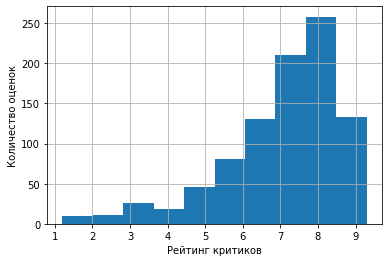

In [433]:
games.query('genre == "Shooter"')['user_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Text(0, 0.5, 'Количество оценок')

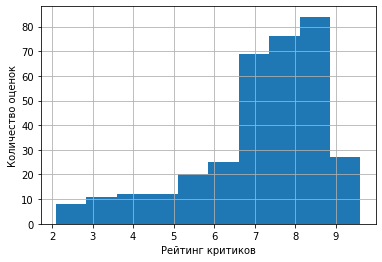

In [434]:
games.query('genre == "Simulation"')['user_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Text(0, 0.5, 'Количество оценок')

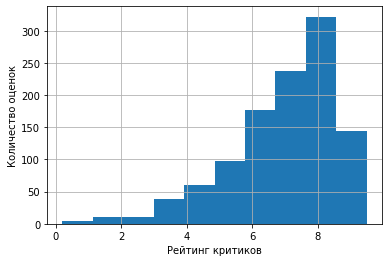

In [435]:
games.query('genre == "Sports"')['user_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Text(0, 0.5, 'Количество оценок')

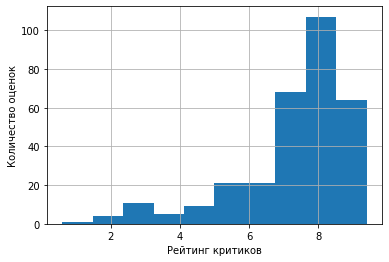

In [436]:
games.query('genre == "Strategy"')['user_score'].hist()
plt.xlabel('Рейтинг критиков')
plt.ylabel('Количество оценок')

Средний пользовательский рейтинг у всех жанров составляет около 7. Пользователи в своих оценках не выделяют какие-то жанры как любимые и отклонений от средней оценки практически нет. А вот у критиков есть любимчики. Это ролевые игры, стратегии и спортивные игры. Отклонение от среднего составляет не велико.

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>

Ты строишь столбчатые диаграммы, а не гистограммы по отзывам длля жанров. О различиях между данными типами графиков читай тут - http://sixsigmaonline.ru/baza-znanij/gistogrammy-chto-ehto-kak-postroit-kak-predstavit-dannye-kak-provesti-analiz. Приведи по 2 графика для каждого жанра. 

</div>


Гистограммы построила, но мне кажется, столбчатые горизонтальные гистограммы информативнее.

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера 2</b></font>

Данная помарка не исправлена. Возможно, финальная версия твоего прооекта не сохранилась. Пожалуйста, приведи необходимые графики. У тебя должно получиться по 2 распределения для каждого жанра. 

</div>

Да, проект почему-то не сохранился в предыдущий раз. Восстановила с предыдущего желтого комментария.

## Проверим гипотезы

Гипотеза № 1: Cредние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Н0 (нулевая гипотеза) - средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
Н1 (альтернативная гипотеза) - средние пользовательские рейтинги платформ Xbox One и PC отличаются между собой.

In [437]:
platform_list = ['XOne', 'PC']
var = actual_games.query('platform == @platform_list').pivot_table(index='platform', values='user_score', aggfunc='var')
var

,user_score
platform,
PC,2.770444
XOne,1.906997


In [438]:
var2 = games.query('platform == @platform_list').pivot_table(index='platform', values='user_score', aggfunc='var')
var2

,user_score
platform,
PC,2.340787
XOne,1.906997


In [439]:
def test_hypotesys(df, fltr, col1, col2, rating, var, a=0.05):
    df1 = df[(df[fltr] == col1) & (df[rating] > 0)][rating]
    df2 = df[(df[fltr] == col2) & (df[rating] > 0)][rating]

    alpha = a
    
    results = st.ttest_ind(df1, df2, equal_var=var)

    print('p-значение:', results.pvalue)


    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [440]:
print('Тестируем с 2012 года:')
test_hypotesys(actual_games, 'platform', 'XOne', 'PC', 'user_score', var=False)
print()
print('Тестируем за всё время:')
test_hypotesys(games, 'platform', 'XOne', 'PC', 'user_score', var=False)

Тестируем с 2012 года:
p-значение: 0.5489537965134912
Не получилось отвергнуть нулевую гипотезу

Тестируем за всё время:
p-значение: 4.935072360183565e-06
Отвергаем нулевую гипотезу


Начиная с 2012 года пользовательские рейтинги для PC и XOne выровнялись, в то время как за весь предоставленный период рейтинги отличаются.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Гипотезы сформулированы и проверены верно.

</div>

Гипотеза № 2: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Н0 (нулевая гипотеза) - средние пользовательские рейтинги жанров Action и Sports одинаковые.
Н1 (альтернативная гипотеза) - средние пользовательские рейтинги жанров Action и Sports разные.

In [441]:
genre_list = ['Action', 'Sports']
var3 = actual_games.query('genre == @genre_list').pivot_table(index='genre', values='user_score', aggfunc='var')
var3

,user_score
genre,
Action,1.889084
Sports,3.022890


In [442]:
genre_list = ['Action', 'Sports']
var3 = games.query('genre == @genre_list').pivot_table(index='genre', values='user_score', aggfunc='var')
var3

,user_score
genre,
Action,2.031747
Sports,2.596515


In [443]:
print('Тестируем с 2012 года:')
test_hypotesys(actual_games, 'genre', 'Action', 'Sports', 'user_score', var=False)
print()
print('Тестируем за всё время:')
test_hypotesys(games, 'genre', 'Action', 'Sports', 'user_score', var=False)

Тестируем с 2012 года:
p-значение: 4.24307776572644e-20
Отвергаем нулевую гипотезу

Тестируем за всё время:
p-значение: 0.11483818791498286
Не получилось отвергнуть нулевую гипотезу


Мы можем наблюдать смену тенденций в игровой индустрии с течением времени.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Проверка второй гипотезы также выполнена без нареканий. 

</div>

## Общие выводы

Начиная с 1990 года и вплоть до 2009 года количество выпускаемых игр ежегодно росло, далее произошел резкий спад в 2008-2011 гг., количество игр уменьшилось почти в 2 раза.

С 2012 г. количество выпускаемых игр стабилизировалось и остается примерно на одном и том же уровне.

Среднее время жизни игровой платформы около 6 лет.

Стандартное отклонение жизни платформы ~4 года, т.е. продолжительность варьируется от 2 до 10 лет.

Наиболее актуальными игровыми платформами на данный момент являются X360, XOne, PS4, а так же Wii, PS3, WiiU, 3DS.

По продажам абсолютно все платформы имеют спад на 4-й \ 5-й год.

Оценки критиков и оценки пользователей не оказывают большого влияния на продажи игр.

Тем не менее оценки критиков оказывают большее влияние на продажи и выручку от продажи игр нежели оценки пользователей.

Наиболее популярными (за всё время) жанрами игр являются Action, Sport и Miscellaneous (игры "смешанного" жанра).

Самыми непопулярными жанрами игр являются Strategy и Puzzle.

Самыми прибыльными являются жанры Action, Sport и Shooter.

На разных континентах разный менталитет -> игровые предпочтения пользователей могут как полностью совпадать, так и координально отличаться.

Прогноз на 2017 год:

продажи будут падать на всех платформах, поэтому наиболее оптимальным решением будет выпуск новой платформы, в зависимости от того, какая страна-производитель её выпустит (и на какую целевую аудиторию эта платформа будет опираться) следует планировать выпуск эксклюзивов по определенным жанрам (например для Европы и Северной Америки это шутеры) дабы привлечь аудиторию.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Выводы описаны грамотно. Приведены ответы на главные вопросы проекта. В выводах можно приводить полученные ранее значения, правильно. Здорово, что по каждому пункту работы приведен вывод.     

</div>

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>

Если тебе нравится тема визуализации, то можешь изучить другие методы библиотеки seaborn. Она позволяет строить довольно презентабельные графики. Здорово, что ты вообще используешь данную библиотеку. 

Ты проделала большую работу, молодец! Критических замечаний почти нет. Разберись с построением гистограмм по жанрам. Однако есть достаточное число желтых комментариев. Думаю, исправить их тебе не составит труда. Надеюсь, ты успеешь до дедлайна. Жду твою работу :)

</div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера 2</b></font>

Часть помарок исправлена, молодец. Однако основной крассный комментарий не устранен. Удели ему особое внимание. Как исправишь данную неточность, присылай проект снова. Постараюсь допроверить его как можно скорее :) 

</div>